In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

## Video segmentation and tracking with SAM 3

This notebook demonstrates how to use SAM 3 for interactive video segmentation and dense tracking. It covers the following capabilities:

- **Text prompts**: Using natural language descriptions to segment objects (e.g., "person", "shoe")
- **Point prompts**: Adding positive/negative clicks to segment and refine objects

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam3/blob/main/notebooks/sam3_video_predictor_example.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>

In [1]:
!nvidia-smi

Fri Nov 21 15:26:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      On  |   00000000:31:00.0 Off |                    0 |
| N/A   40C    P0             24W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Set-up

In this example, we allow running inference either on a single GPU or multiple GPUs.

In [2]:
from utils import bbox_iou, mask_iou, sample_points_from_mask, mask_to_bbox

In [3]:
import os
import sam3
import torch

sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")

# use all available GPUs on the machine
#gpus_to_use = range(torch.cuda.device_count())
# # use only a single GPU
gpus_to_use = [torch.cuda.current_device()]

In [4]:
from sam3.model_builder import build_sam3_video_predictor

predictor = build_sam3_video_predictor(gpus_to_use=gpus_to_use)

INFO 2025-11-21 15:27:02,051 195081 sam3_video_predictor.py: 299: using the following GPU IDs: [0]
INFO 2025-11-21 15:27:02,052 195081 sam3_video_predictor.py: 315: 


	*** START loading model on all ranks ***


INFO 2025-11-21 15:27:02,052 195081 sam3_video_predictor.py: 317: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2025-11-21 15:27:09,096 195081 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2025-11-21 15:27:11,992 195081 sam3_video_predictor.py: 319: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2025-11-21 15:27:11,992 195081 sam3_video_predictor.py: 330: 


	*** DONE loading model on all ranks ***




#### Inference and visualization utils

In [ ]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sam3.visualization_utils import (
    load_frame,
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
    save_masklet_video,
    show_box,
    show_mask, 
    show_points,
)

# font size for axes titles
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12


def propagate_in_video(predictor, session_id):
    # we will just propagate from frame 0 to the end of the video
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]

    return outputs_per_frame


def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type="point"):
    """Convert absolute coordinates to relative coordinates (0-1 range)

    Args:
        coords: List of coordinates
        coord_type: 'point' for [x, y] or 'box' for [x, y, w, h]
    """
    if coord_type == "point":
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == "box":
        return [
            [x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT]
            for x, y, w, h in coords
        ]
    else:
        raise ValueError(f"Unknown coord_type: {coord_type}")

### Loading an example video

We assume that the video is stored as either **a list of JPEG frames with filenames like `<frame_index>.jpg`** or **an MP4 video**.

Note that you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

In [6]:
# "video_path" needs to be either a JPEG folder or a MP4 video file
video_path = "/data/engine_reite_results/vCai6dwL1CzXj0bpF1U7/ext_top/frames" # f"{sam3_root}/assets/videos/0001"

In [7]:
# load "video_frames_for_vis" for visualization purposes (they are not used by the model)
if isinstance(video_path, str) and video_path.endswith(".mp4"):
    cap = cv2.VideoCapture(video_path)
    video_frames_for_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        video_frames_for_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
else:
    video_frames_for_vis = glob.glob(os.path.join(video_path, "*.jpg"))
    try:
        # integer sort instead of string sort (so that e.g. "2.jpg" is before "11.jpg")
        video_frames_for_vis.sort(
            key=lambda p: int(os.path.splitext(os.path.basename(p))[0])
        )
    except ValueError:
        # fallback to lexicographic sort if the format is not "<frame_index>.jpg"
        print(
            f'frame names are not in "<frame_index>.jpg" format: {video_frames_for_vis[:5]=}, '
            f"falling back to lexicographic sort."
        )
        video_frames_for_vis.sort()

### Opening an inference session on this video

SAM 3 requires stateful inference for interactive video segmentation, so we need to initialize an **inference session** on this video.

During initialization, it loads all the video frames and stores their pixels in the session state.

In [8]:
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=video_path,
    )
)
session_id = response["session_id"]

frame loading (image folder) [rank=0]: 100%|██████████| 483/483 [00:05<00:00, 82.64it/s]


### Video promptable concept segmentation with text

Using SAM 3 you can describe objects using natural language, and the model will automatically detect and track all instances of that object throughout the video.

In the example below, we add a text prompt on frame 0 and propagation throughout the video. Here we use the text prompt "person" to detect all people in the video. SAM 3 will automatically identify multiple person instances and assign each a unique object ID.

Note that the first call might be slower due to setting up buffers. **You can rerun all the cells below when measuring speed.**

In [9]:
# note: in case you already ran one text prompt and now want to switch to another text prompt
# it's required to reset the session first (otherwise the results would be wrong)
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

In [10]:
prompt_text_list = ["right hand", "left hand", "cellphone", "small object"]
frame_idx = 278 # add a text prompt on frame 0
outs = None
new_ids_to_keep = None
for prompt_text_str in prompt_text_list:
    print(f"Processing prompt: {prompt_text_str}")

    _ = predictor.handle_request(
        request=dict(
            type="reset_session",
            session_id=session_id,
        )
    )
    
    response = predictor.handle_request(
        request=dict(
            type="add_prompt",
            session_id=session_id,
            frame_index=frame_idx,
            text=prompt_text_str
        )
    )
    out = response["outputs"]
    init_keep_ids = [id for id in np.arange(out["out_obj_ids"].shape[0]) if out["out_probs"][id]>0.6]
    
    if prompt_text_str == "small object" and len(init_keep_ids)==0:
        print("No small object found, discarding this frame")
    
    out["out_obj_ids"] = np.arange(len(init_keep_ids))
    for key in out:
        if isinstance(out[key], np.ndarray) and key!="out_obj_ids":
            out[key] = out[key][init_keep_ids]
        elif isinstance(out[key], dict):
            k = "num_obj_tracked"
            out[key][k] = len(init_keep_ids)
        
    if outs is None:
        outs = out
        outs["labels"] = [prompt_text_str]*len(outs["out_obj_ids"])
    else:
        new_ids_to_delete = []
        old_ids_to_delete = []
        object_ids_to_keep = []
        if prompt_text_str == "small object":
            for ndx, object_mask in enumerate(out["out_binary_masks"]):
                for odx, old_mask in enumerate(outs["out_binary_masks"]):
                    if outs["labels"][odx] == "cellphone":
                        iou = mask_iou(object_mask, old_mask)
                        if iou > 0.5:
                            new_ids_to_delete.append(ndx)
                            old_ids_to_delete.append(odx)
                    elif outs["labels"][odx] == "right hand" or outs["labels"][odx] == "left_hand":
                        object_bbox = mask_to_bbox(object_mask)
                        hand_bbox = mask_to_bbox(old_mask)
                        hand_small_object_iou = bbox_iou(object_bbox, hand_bbox)
                        if hand_small_object_iou > 0.1 and out["out_obj_ids"][ndx] not in object_ids_to_keep:
                            object_ids_to_keep.append(out["out_obj_ids"][ndx]) 
        new_ids_to_keep = [id for id in object_ids_to_keep if id not in new_ids_to_delete]
        new_ids_to_delete = [id for id in np.arange(out["out_binary_masks"].shape[0]) if id not in new_ids_to_keep]
        old_ids_to_keep = [id for id in np.arange(outs["out_binary_masks"].shape[0]) if id not in old_ids_to_delete]
        
        for key in outs.keys():
            if key == "out_obj_ids":
                current_instances = len(outs[key][old_ids_to_keep])
                new_instances = len(out[key][new_ids_to_keep])
                joined_instances = current_instances + new_instances
                outs[key] = np.arange(joined_instances)
            elif key == "labels":
                outs[key] = np.array(outs[key])[old_ids_to_keep].tolist() + [prompt_text_str]*len(out["out_obj_ids"][new_ids_to_keep])
            elif isinstance(outs[key], np.ndarray):
                new_key_item = np.concatenate([outs[key][old_ids_to_keep], out[key][new_ids_to_keep]], axis=0)
                outs[key] = new_key_item
            elif isinstance(outs[key], dict):
                k = "num_obj_tracked"
                outs[key][k] = len(old_ids_to_keep) + len(new_ids_to_keep)
if "right hand" not in outs["labels"] and "left hand" not in outs["labels"]:
    print("No hands detected, discarding this frame")

Processing prompt: right hand


Processing prompt: left hand
Processing prompt: cellphone
Processing prompt: small object


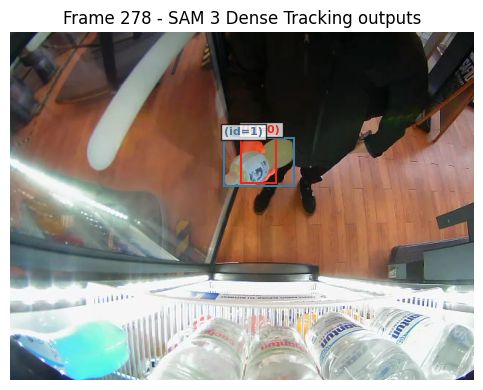

In [11]:
plt.close("all")
visualize_formatted_frame_output(
    frame_idx,
    video_frames_for_vis,
    outputs_list=[prepare_masks_for_visualization({frame_idx: outs})],
    titles=["SAM 3 Dense Tracking outputs"],
    figsize=(6, 4),
)

In [12]:
# finally, close the inference session to free its GPU resources
# (you may start a new session on another video)
_ = predictor.handle_request(
    request=dict(
        type="close_session",
        session_id=session_id,
    )
)
# after all inference is done, we can shutdown the predictor
# to free up the multi-GPU process group
predictor.shutdown()

INFO 2025-11-21 15:27:28,732 195081 sam3_video_predictor.py: 250: removed session 80b556ec-de55-4424-9076-6298c2dfd396; live sessions: [], GPU memory: 5106 MiB used and 9112 MiB reserved (max over time: 8661 MiB used and 9112 MiB reserved)


In [26]:
from sam3.model_builder import build_sam3_video_model

sam3_model = build_sam3_video_model()
predictor = sam3_model.tracker
predictor.backbone = sam3_model.detector.backbone

INFO 2025-11-21 15:39:05,059 195081 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16


In [ ]:
inference_state = predictor.init_state(video_path=video_path)

frame loading (JPEG): 100%|██████████| 483/483 [00:08<00:00, 59.65it/s]


In [33]:
predictor.clear_all_points_in_video(inference_state)

In [36]:
frame0 = cv2.cvtColor(cv2.imread(video_frames_for_vis[0]), cv2.COLOR_BGR2RGB)
width, height = frame0.shape[1], frame0.shape[0]

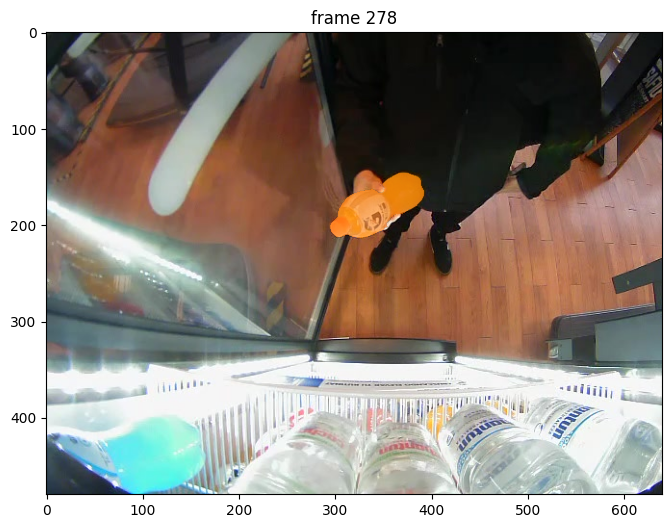

In [37]:
for idx in range(len(outs["labels"])):
    if idx == 0:
        continue
    # Let's add a box at (x_min, y_min, x_max, y_max) = (300, 0, 500, 400) to get started
    box = outs["out_boxes_xywh"][idx]

    rel_box = [box[0], box[1], box[0]+box[2], box[1]+box[3]]
    rel_box = np.array(rel_box, dtype=np.float32)

    _, out_obj_ids, low_res_masks, video_res_masks  = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=frame_idx,
        obj_id=idx,
        box=rel_box,
    )

    # show the results on the current (interacted) frame
    plt.figure(figsize=(9, 6))
    plt.title(f"frame {frame_idx}")
    plt.imshow(cv2.cvtColor(cv2.imread(video_frames_for_vis[frame_idx]), cv2.COLOR_BGR2RGB))
    show_box(box, plt.gca())
    show_mask((video_res_masks[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=idx)
    break

In [50]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for frame_idx, obj_ids, low_res_masks, video_res_masks, obj_scores in predictor.propagate_in_video(inference_state, start_frame_idx=278, max_frame_num_to_track=500, reverse=False, propagate_preflight=True):
    video_segments[frame_idx] = {
        out_obj_id: (video_res_masks[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video:   0%|          | 0/205 [00:00<?, ?it/s]

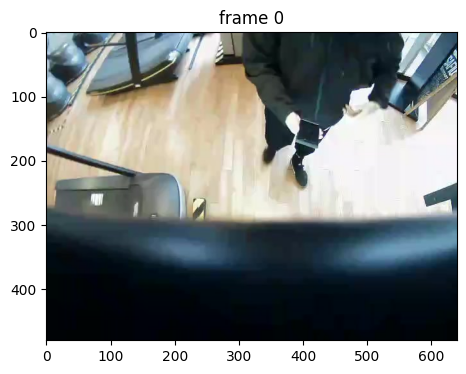

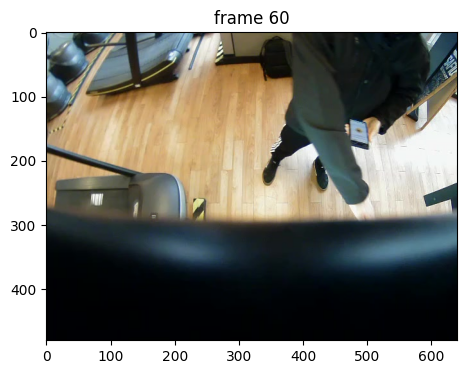

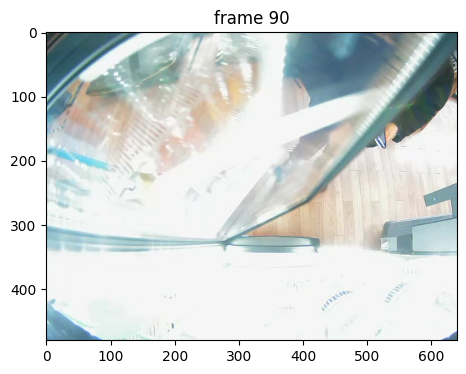

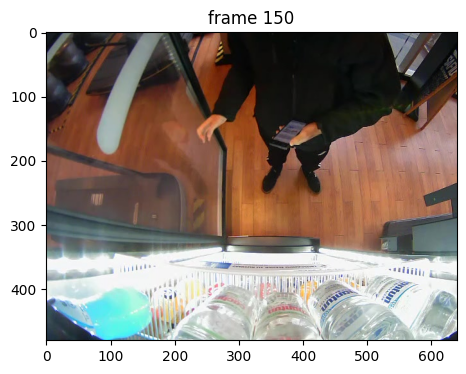

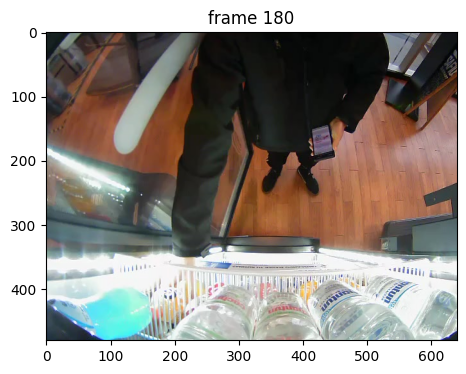

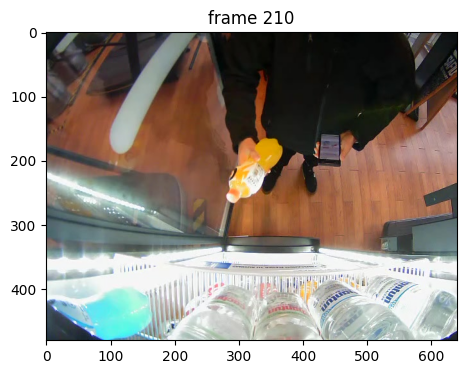

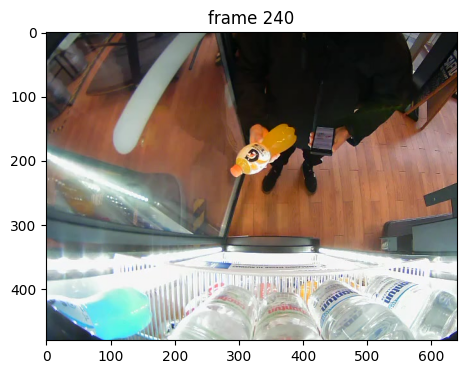

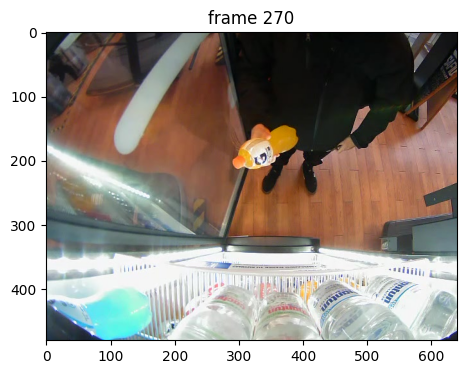

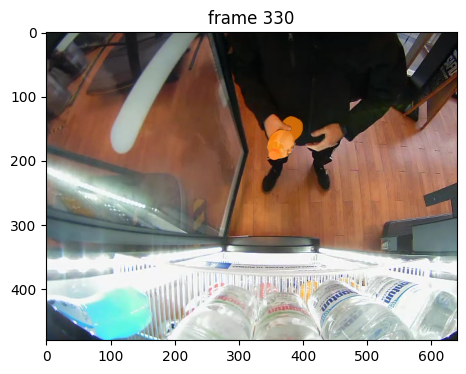

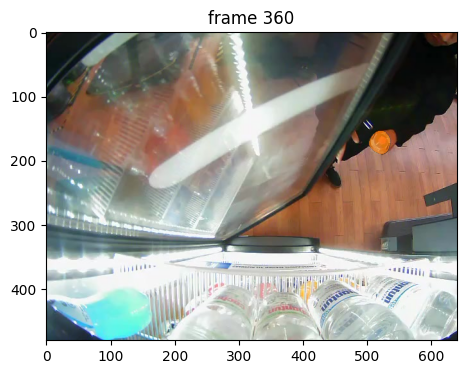

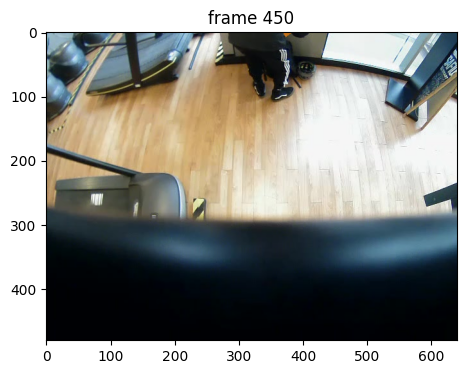

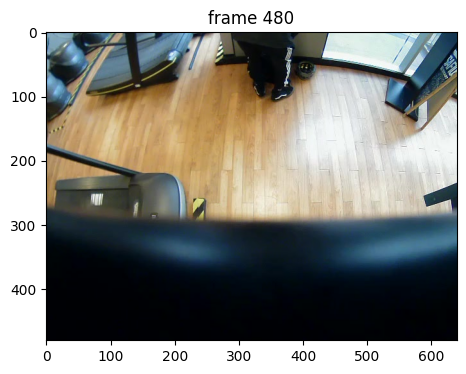

In [51]:
# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(video_frames_for_vis), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(cv2.cvtColor(cv2.imread(video_frames_for_vis[out_frame_idx]), cv2.COLOR_BGR2RGB))
    if out_frame_idx in video_segments:
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [ ]:
save_path = video_path.replace("frames", "vis")
os.makedirs(save_path, exist_ok=True)
save_name = "test.mp4"
save_masklet_video(video_frames = video_frames_for_vis, outputs = outputs_per_frame, out_path=os.path.join(save_path, save_name))

100%|██████████| 483/483 [00:01<00:00, 295.59it/s]
ffmpeg version 7.0.2-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      59.  8.100 / 59.  8.100
  liba

Re-encoded video saved to /data/engine_reite_results/vCai6dwL1CzXj0bpF1U7/ext_top/vis/test.mp4


[out#0/mp4 @ 0x21f96a40] video:4233KiB audio:0KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.125947%
frame=  483 fps=261 q=-1.0 Lsize=    4238KiB time=00:00:48.10 bitrate= 721.8kbits/s speed=  26x    
[libx264 @ 0x21f91580] frame I:2     Avg QP:17.97  size: 39135
[libx264 @ 0x21f91580] frame P:289   Avg QP:19.94  size: 12559
[libx264 @ 0x21f91580] frame B:192   Avg QP:23.25  size:  3260
[libx264 @ 0x21f91580] consecutive B-frames: 37.7% 22.8% 15.5% 24.0%
[libx264 @ 0x21f91580] mb I  I16..4: 15.5% 72.1% 12.4%
[libx264 @ 0x21f91580] mb P  I16..4:  1.7% 10.5%  0.9%  P16..4: 43.3% 16.5% 12.7%  0.0%  0.0%    skip:14.4%
[libx264 @ 0x21f91580] mb B  I16..4:  0.7%  4.1%  0.2%  B16..8: 36.3%  5.1%  1.4%  direct: 4.2%  skip:48.0%  L0:48.2% L1:35.0% BI:16.8%
[libx264 @ 0x21f91580] 8x8 transform intra:80.0% inter:84.3%
[libx264 @ 0x21f91580] coded y,uvDC,uvAC intra: 59.1% 72.8% 28.7% inter: 30.5% 32.8% 5.3%
[libx264 @ 0x21f91580] i16 v,h,dc,p: 26% 35% 20% 19%
[libx264 

### Close session

Each session is tied to a single video. We can close the session after inference to free up its resources.

(Then, you may start a new session on another video.)

In [ ]:
# finally, close the inference session to free its GPU resources
# (you may start a new session on another video)
_ = predictor.handle_request(
    request=dict(
        type="close_session",
        session_id=session_id,
    )
)

### Clean-up

After all inference is done, we can shutdown the predictor to free up the multi-GPU process group.

In [ ]:
# after all inference is done, we can shutdown the predictor
# to free up the multi-GPU process group
predictor.shutdown()